><h2><center> Advanced Regression Techniques / Analysis of house price in California
<h3><center>Ali Behroozfar
   
 <br><br>In this project I tried to find the best regression models to explain the housing price in CA. Different regression models were tuned, run and compared with each other. All the data cleaning, visualizations and models evaluations are explained below. The dataset is available online and can be downloaded at this link:<br><br> https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview




In [66]:
import collections
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.exceptions import DataConversionWarning
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import accuracy_score
np.random.seed(0)
from scipy.special import boxcox1p

In [2]:
df=pd.read_csv('train.csv')

In [3]:
print('The shape of this dataset is : {}'.format(df.shape))

The shape of this dataset is : (1460, 81)


In [4]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

**It has 6 percent missing values.**

In [5]:
df.isnull().values.sum()/df.shape[0]/df.shape[1]

0.058895653644512096

### Choosing variables

> These variables have missing values:

In [6]:
null_col = df.isnull().sum()
pd.DataFrame(null_col[null_col>0])

,0
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


### Droping variables containing high number of missing values

In [8]:
df['SalePrice_Log'] = np.log(df['SalePrice'])

In [9]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
categorical_feats = df.dtypes[df.dtypes == "object"].index

In [10]:
categorical_feats

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df[col].fillna('None',inplace=True)

In [12]:
df.mean()

Id                  730.500000
MSSubClass           56.897260
LotFrontage          70.049958
LotArea           10516.828082
OverallQual           6.099315
OverallCond           5.575342
YearBuilt          1971.267808
YearRemodAdd       1984.865753
MasVnrArea          103.685262
BsmtFinSF1          443.639726
BsmtFinSF2           46.549315
BsmtUnfSF           567.240411
TotalBsmtSF        1057.429452
1stFlrSF           1162.626712
2ndFlrSF            346.992466
LowQualFinSF          5.844521
GrLivArea          1515.463699
BsmtFullBath          0.425342
BsmtHalfBath          0.057534
FullBath              1.565068
HalfBath              0.382877
BedroomAbvGr          2.866438
KitchenAbvGr          1.046575
TotRmsAbvGrd          6.517808
Fireplaces            0.613014
GarageYrBlt        1978.506164
GarageCars            1.767123
GarageArea          472.980137
WoodDeckSF           94.244521
OpenPorchSF          46.660274
EnclosedPorch        21.954110
3SsnPorch             3.409589
ScreenPo

In [13]:
df.fillna(df.mean(), inplace=True)

In [14]:
df.isnull().sum().sum()

0

In [15]:
df['GrLivArea_Log'] = np.log(df['GrLivArea'])
df.drop('GrLivArea', inplace= True, axis = 1)
df['LotArea_Log'] = np.log(df['LotArea'])
df.drop('LotArea', inplace= True, axis = 1)
    
numerical_feats = df.dtypes[df.dtypes != "object"].index

In [17]:
df = df.drop(
    df[(df['OverallQual']==10) & (df['SalePrice_Log']<12.3)].index)

In [19]:
df = df.drop(
    df[(df['GrLivArea_Log']>8.3) & (df['SalePrice_Log']<12.5)].index)

In [20]:
df.shape

(1458, 82)

In [21]:
column_to_drop = ['Id', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'BsmtFullBath', 
                  'BsmtUnfSF', 'BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'ScreenPorch', 'PoolArea', 'MSSubClass',
                  'MoSold','3SsnPorch', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'Id', 'BsmtHalfBath',
                  'BsmtFinSF2', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
                  'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                  'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                  'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleCondition', 'Condition2', 
                  'MasVnrType', 'CentralAir', 'Electrical', 'SaleType']
df.drop(column_to_drop, axis=1, inplace=True)

In [22]:
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 

nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']     

In [23]:
df['MSZ_num'] = 1  
df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        

df['NbHd_num'] = 1       
df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

df['ExtQ_num'] = 1       
df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     

df['BsQ_num'] = 1          
df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     

df['KiQ_num'] = 1       
df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 26 columns):
MSZoning         1458 non-null object
Neighborhood     1458 non-null object
OverallQual      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
MasVnrArea       1458 non-null float64
ExterQual        1458 non-null object
BsmtQual         1458 non-null object
TotalBsmtSF      1458 non-null int64
1stFlrSF         1458 non-null int64
FullBath         1458 non-null int64
KitchenQual      1458 non-null object
TotRmsAbvGrd     1458 non-null int64
Fireplaces       1458 non-null int64
GarageYrBlt      1458 non-null float64
GarageCars       1458 non-null int64
GarageArea       1458 non-null int64
SalePrice        1458 non-null int64
SalePrice_Log    1458 non-null float64
GrLivArea_Log    1458 non-null float64
LotArea_Log      1458 non-null float64
MSZ_num          1458 non-null int64
NbHd_num         1458 non-null int64
ExtQ_num         1458 non-n

In [25]:
col_to_drop = ['SalePrice', 'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'MSZoning',
              'Neighborhood' , 'ExterQual', 'BsmtQual','KitchenQual']
df.drop(col_to_drop, axis=1, inplace=True)

In [26]:
df.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,FullBath,Fireplaces,GarageCars,SalePrice_Log,GrLivArea_Log,LotArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,7,2003,2003,196.0,856,2,0,2,12.247694,7.444249,9.041922,3,2,3,2,3
1,6,1976,1976,0.0,1262,2,1,2,12.109011,7.140453,9.169518,3,2,2,2,2
2,7,2001,2002,162.0,920,2,1,2,12.317167,7.487734,9.328123,3,2,3,2,3
3,7,1915,1970,0.0,756,1,1,3,11.849398,7.448334,9.164296,3,2,2,1,3
4,8,2000,2000,350.0,1145,2,1,3,12.429216,7.695303,9.565214,3,3,3,2,3


In [27]:
df1 = df.copy()
sc = MinMaxScaler()
val = sc.fit_transform(df.values)
df1[df.columns] = val

In [31]:
df1.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,FullBath,Fireplaces,GarageCars,SalePrice_Log,GrLivArea_Log,LotArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,0.666667,0.949275,0.883333,0.12250,0.266999,0.666667,0.000000,0.50,0.581431,0.629245,0.366344,1.0,0.5,0.666667,0.5,0.666667
1,0.555556,0.753623,0.433333,0.00000,0.393637,0.666667,0.333333,0.50,0.536319,0.512191,0.391317,1.0,0.5,0.333333,0.5,0.333333
2,0.666667,0.934783,0.866667,0.10125,0.286962,0.666667,0.333333,0.50,0.604029,0.646000,0.422359,1.0,0.5,0.666667,0.5,0.666667
3,0.666667,0.311594,0.333333,0.00000,0.235808,0.333333,0.333333,0.75,0.451871,0.630819,0.390295,1.0,0.5,0.333333,0.0,0.666667
4,0.777778,0.927536,0.833333,0.21875,0.357143,0.666667,0.333333,0.75,0.640477,0.725978,0.468761,1.0,1.0,0.666667,0.5,0.666667


In [32]:
y = df1['SalePrice_Log']
X = df1.drop(columns=['SalePrice_Log'], axis= 1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

### KNN regressor

Text(0, 0.5, 'MSE')

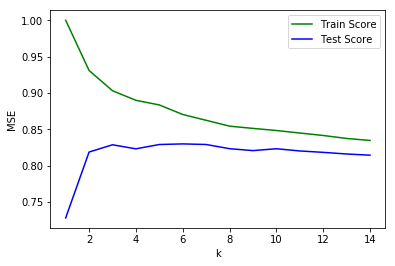

In [34]:
%matplotlib inline
train_score_array = []
test_score_array = []

for k in range(1,15):
    knn_reg = KNeighborsRegressor(k)
    knn_reg.fit(X_train, y_train)
    train_score_array.append(knn_reg.score(X_train, y_train))
    test_score_array.append(knn_reg.score(X_test, y_test))

x_axis = range(1,15)
plt.plot(x_axis, train_score_array, c = 'g', label = 'Train Score')
plt.plot(x_axis, test_score_array, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('k')
plt.ylabel('MSE')

In [35]:
    knn_reg = KNeighborsRegressor(10)
    knn_reg.fit(X_train, y_train)
    train_score_array.append(knn_reg.score(X_train, y_train))
    test_score_array.append(knn_reg.score(X_test, y_test))
    print(knn_reg.score(X_train, y_train))
    print(knn_reg.score(X_test, y_test))

0.8483053873804012
0.8232262831609938


### Linear regression

In [36]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)
print(lreg.score(X_train, y_train))
print(lreg.score(X_test, y_test))

0.8874845798922909
0.8841954827434313


### SGD regression

In [37]:
sgd_reg = SGDRegressor(max_iter = 10000, penalty = 'l1')
sgd_reg.fit(X_train, y_train)
print(sgd_reg.score(X_train, y_train))
print(sgd_reg.score(X_test, y_test))

C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.8872223565703993
0.8833405097061966


In [47]:
sgd_reg.intercept_

array([-0.02047816])

### Polynomial

In [51]:
train_score_list = []
test_score_list = []

for n in [1 , 2]:
    #polynomialFeatures is an unsupervised learning mode
    poly = PolynomialFeatures(n)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    lreg.fit(X_train_poly, y_train)
    train_score_list.append(lreg.score(X_train_poly, y_train))
    test_score_list.append(lreg.score(X_test_poly, y_test))

print(train_score_list)
print(test_score_list)

[0.8874845798922909, 0.9145508036568522]
[0.8841954827434308, 0.877355392061856]


### Ridge

In [52]:
x_range = [0.01, 0.1, 1, 10, 100]
train_score_list = []
test_score_list = []

for alpha in x_range: 
    ridge = Ridge(alpha)
    ridge.fit(X_train,y_train)
    train_score_list.append(ridge.score(X_train,y_train))
    test_score_list.append(ridge.score(X_test, y_test))

Text(0.5, 0, '$\\alpha$')

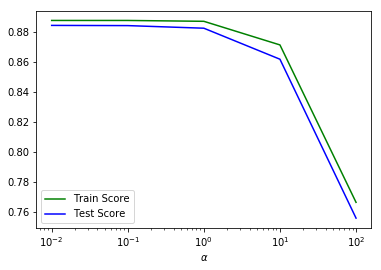

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x_range, train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_range, test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')

### Lasso

In [61]:
x_range = [0.001, 0.01]
train_score_list = []
test_score_list = []

for alpha in x_range: 
    lasso = Lasso(alpha)
    lasso.fit(X_train,y_train)
    train_score_list.append(lasso.score(X_train,y_train))
    test_score_list.append(lasso.score(X_test, y_test))

Text(0.5, 0, '$\\alpha$')

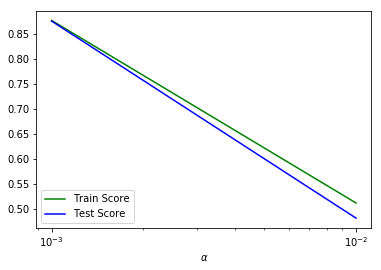

In [62]:
plt.plot(x_range, train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_range, test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')

### SVR kernel Linear

In [63]:
svr_lin = SVR(kernel='linear', C=10, gamma=0.1)
svr_lin.fit(X_train,y_train)
print(svr_lin.score(X_train, y_train))
print(svr_lin.score(X_test, y_test))

0.859642757307469
0.8503953653146945


### SVR kernel Poly

In [64]:
svr_pol = SVR(kernel='poly',C=10, gamma=0.1)
svr_pol.fit(X_train,y_train)
print(svr_pol.score(X_train, y_train))
print(svr_pol.score(X_test, y_test))

0.8365214082055668
0.8016739974799449


### SVR kernel rbf

In [65]:
svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1)
svr_rbf.fit(X_train,y_train)
print(svr_rbf.score(X_train, y_train))
print(svr_rbf.score(X_test, y_test))

0.8528292032075967
0.8439555847078803


### Linear SVR

In [67]:
linear_svm=LinearSVR(tol=0.0001,C=1.0,loss='epsilon_insensitive',fit_intercept=True,intercept_scaling=1.0,
    dual=True,verbose=0,max_iter=1000,)
linear_svm.fit(X_train,y_train)
print(linear_svm.score(X_train, y_train))
print(linear_svm.score(X_test, y_test))

0.8828855317150162
0.8800728865051283


C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Grid Search

In [68]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
gs = GridSearchCV(LinearRegression(), parameters, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_linear = gs.best_score_

Best params: {'fit_intercept': False, 'normalize': True}
Best training accuracy: 0.880434


In [69]:
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
gs = GridSearchCV(ridge, parameters, cv=5,)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_ridge = gs.best_score_

Best params: {'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Best training accuracy: 0.880186


In [70]:
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
gs = GridSearchCV(Lasso(), parameters, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_lasso = gs.best_score_

Best params: {'alpha': 0.001, 'normalize': False, 'tol': 0.001}
Best training accuracy: 0.869622


In [344]:
parameters = { 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(SVR(), parameters, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_svr_rbf = gs.best_score_

Best params: {'C': 100, 'gamma': 0.01}
Best training accuracy: 0.852136


In [345]:
parameters = { 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(SVR(kernel='linear'), parameters, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_svr_linear = gs.best_score_

Best params: {'C': 10, 'gamma': 0.001}
Best training accuracy: 0.853088


In [346]:
parameters = { 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(SVR(kernel='poly'), parameters, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_svr_poly = gs.best_score_

Best params: {'C': 1, 'gamma': 0.1}
Best training accuracy: 0.814743


C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [347]:
parameters = { 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'tol':[0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(LinearSVR(), parameters, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_linear_svr = gs.best_score_

C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

Best params: {'C': 0.1, 'tol': 0.001}
Best training accuracy: 0.877724


C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [72]:
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-03, 1e-02, 1e-01], 'fit_intercept' : [True]}
gs = GridSearchCV(SGDRegressor(random_state=1250), parameters, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_sgd = gs.best_score_

C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegres

Best params: {'alpha': 1e-05, 'epsilon': 0.001, 'fit_intercept': True, 'max_iter': 10000}
Best training accuracy: 0.880035


In [74]:
param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True]}
            
gs = GridSearchCV(DecisionTreeRegressor(random_state=1250), param_grid, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_dtree = gs.best_score_

Best params: {'max_depth': 8, 'max_features': 11, 'max_leaf_nodes': None, 'min_samples_split': 20, 'presort': False}
Best training accuracy: 0.769035


In [75]:
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100]}
gs = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_rf = gs.best_score_

Best params: {'min_samples_split': 4, 'n_estimators': 100}
Best training accuracy: 0.860306


In [76]:
param_grid = {'n_neighbors' : [3,4,5,6,7,8,10,12,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

gs = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_knn = gs.best_score_

Best params: {'algorithm': 'brute', 'n_neighbors': 8, 'weights': 'distance'}
Best training accuracy: 0.809613


In [348]:
list_scores = [sc_linear, sc_ridge, sc_lasso, sc_svr_rbf,sc_svr_linear,sc_svr_poly,sc_linear_svr, sc_sgd, sc_dtree, sc_rf, sc_knn]
list_regressors = ['Linear','Ridge','Lasso', 'SVR_rbf','SVR_linear','SVR_poly','Linear_SVR', 'SGD','DTr','RF','KNN']

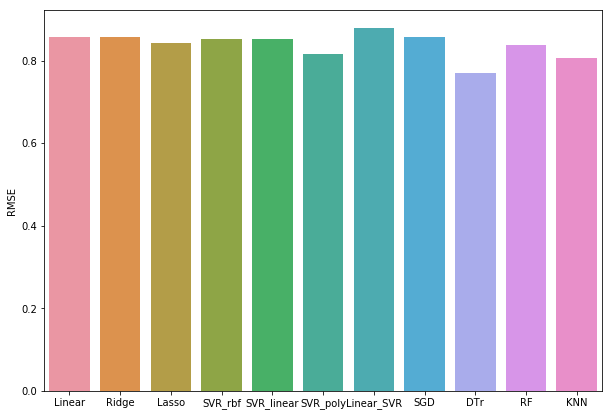

In [349]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

# <font color='red'> Final Project

### Apply any two models with Bagging and any two models with Pasting

we applied "Decision Tree regressor" and "KNN regressor" with bagging 
            and 
           "Decision Tree regressor" and "KNN regressor" with pasting:

In [79]:
dt = DecisionTreeRegressor(max_depth=8, max_features=11, max_leaf_nodes=None, min_samples_split=20, presort=False)
bag1 = BaggingRegressor(dt, n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True, random_state=1250)

bag1.fit(X_train, y_train)
bag1.oob_score_

0.858481604039941

In [80]:
knn = KNeighborsRegressor(algorithm= 'brute', n_neighbors=8, weights= 'distance')
bag2 = BaggingRegressor(knn, n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True, random_state=1250)

bag2.fit(X_train, y_train)
bag2.oob_score_

0.8214073312454437

In [81]:
dt = DecisionTreeRegressor(max_depth=8, max_features=11, max_leaf_nodes=None, min_samples_split=20, presort=False)
paste1 = BaggingRegressor(dt, n_estimators=500, bootstrap=False, n_jobs=-1, random_state=1250)

paste1.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(paste1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(paste1.score(X_test, y_test)))

Accuracy on training set: 0.938
Accuracy on test set: 0.855


In [82]:
svr = SVR(C=100, gamma=0.01)
paste2 = BaggingRegressor(svr, n_estimators=500, bootstrap=False, n_jobs=-1, random_state=1250)

paste2.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(paste2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(paste2.score(X_test, y_test)))

Accuracy on training set: 0.864
Accuracy on test set: 0.854


### Apply any two models with AdaBoost

We applied "Decision Tree regressor" and "SVR" with Adaboost for this section:

In [83]:
dt = DecisionTreeRegressor(max_depth=8, max_features=11, max_leaf_nodes=None, min_samples_split=20, presort=False)
ada1 = AdaBoostRegressor(dt, n_estimators=500, learning_rate=0.5, random_state=1250)

ada1.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(ada1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(ada1.score(X_test, y_test)))

Accuracy on training set: 0.969
Accuracy on test set: 0.881


In [84]:
svr = SVR(C=100, gamma=0.01)
ada2 = AdaBoostRegressor(svr, n_estimators=500, learning_rate=0.1, random_state=1250)

ada2.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(ada2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(ada2.score(X_test, y_test)))

Accuracy on training set: 0.847
Accuracy on test set: 0.834


### Apply one model with Gradient Boosting:


In [85]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [86]:
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.916
Accuracy on test set: 0.893


## Principal Component Analysis (PCA)

Here, we choose the features which describe 95% of the variations in the dataset:

In [87]:
pca = PCA(n_components=.95)

X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [88]:
pca.explained_variance_ratio_

array([0.53917247, 0.10149298, 0.0671051 , 0.05391313, 0.04945221,
       0.0383227 , 0.03637004, 0.02563491, 0.02254668, 0.01737133])

### Linear regression with PCA features:

In [350]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
gs = GridSearchCV(LinearRegression(), parameters, cv=5)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_linear_pca = gs.best_score_

Best params: {'fit_intercept': True, 'normalize': False}
Best training accuracy: 0.857931


### Ridge with PCA features

In [351]:
ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
gs = GridSearchCV(ridge, parameters, cv=5,)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_ridge_pca = gs.best_score_

Best params: {'alpha': 0.5, 'normalize': False, 'tol': 1e-06}
Best training accuracy: 0.858008


### Lasso with PCA features

In [352]:
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
gs = GridSearchCV(Lasso(), parameters, cv=5)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_lasso_pca = gs.best_score_

Best params: {'alpha': 0.001, 'normalize': False, 'tol': 0.0001}
Best training accuracy: 0.841758


### SVR (rbf) with PCA features

In [353]:
parameters = { 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(SVR(), parameters, cv=5)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_svr_rbf_pca = gs.best_score_

Best params: {'C': 10, 'gamma': 0.01}
Best training accuracy: 0.836626


### SVR (linear) with PCA features

In [355]:
parameters = { 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(SVR(kernel='linear'), parameters, cv=5)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_svr_linear_pca = gs.best_score_

Best params: {'C': 10, 'gamma': 0.001}
Best training accuracy: 0.835989


### SVR (poly) with PCA features

In [ ]:
parameters = { 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(SVR(kernel='poly'), parameters, cv=5)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_svr_poly_pca = gs.best_score_

### Linear SVR with PCA features

In [358]:
parameters = { 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'tol':[0.001, 0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(LinearSVR(), parameters, cv=5)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_linear_svr_pca = gs.best_score_

C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

Best params: {'C': 0.1, 'tol': 0.001}
Best training accuracy: 0.855908


C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### SGD Regressor with PCA features

In [93]:
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-03, 1e-02, 1e-01], 'fit_intercept' : [True]}
gs = GridSearchCV(SGDRegressor(random_state=1250), parameters, cv=5)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_sgd_pca = gs.best_score_

C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Alex\Anaconda3.7\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegres

Best params: {'alpha': 1e-05, 'epsilon': 0.001, 'fit_intercept': True, 'max_iter': 10000}
Best training accuracy: 0.857935


### Decision tree regressor with PCA features

In [94]:
param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True]}
            
gs = GridSearchCV(DecisionTreeRegressor(random_state=1250), param_grid, cv=5)
gs.fit(X_train, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_dtree_pca = gs.best_score_

Best params: {'max_depth': 8, 'max_features': 11, 'max_leaf_nodes': None, 'min_samples_split': 20, 'presort': False}
Best training accuracy: 0.769035


### Random forest regressor with PCA features

In [95]:
param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100]}
gs = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_rf_pca = gs.best_score_

Best params: {'min_samples_split': 10, 'n_estimators': 100}
Best training accuracy: 0.838769


### KNN regressor with PCA features

In [96]:
param_grid = {'n_neighbors' : [3,4,5,6,7,8,10,12,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

gs = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
gs.fit(X_train_reduced, y_train)
print('Best params: {}'.format(gs.best_params_))
print('Best training accuracy: {:3f}'.format(gs.best_score_))
sc_knn_pca = gs.best_score_

Best params: {'algorithm': 'ball_tree', 'n_neighbors': 8, 'weights': 'distance'}
Best training accuracy: 0.805846


In [97]:
list_scores = [sc_linear_pca_pca, sc_ridge_pca, sc_lasso_pca, sc_svr_rbf_pca,sc_svr_linear_pca,sc_svr_poly_pca,sc_linear_svr_pca, sc_sgd_pca, sc_dtree_pca, sc_rf_pca, sc_knn_pca]
list_regressors = ['Linear','Ridge','Lasso', 'SVR', 'SGD','DTr','RF','KNN']

### The graph below shows the accuracy score of the models mentioned above (with PCA features) 

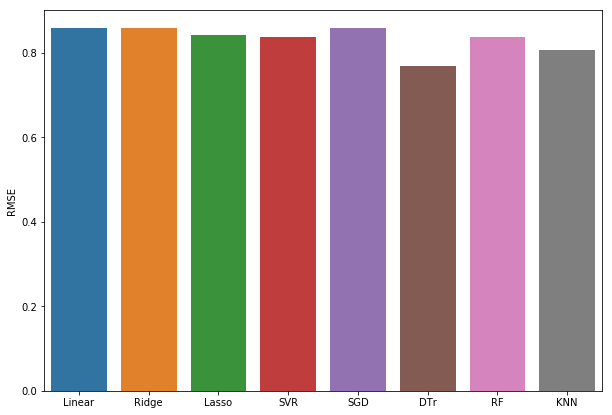

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

In [339]:
list_scores

[0.8579313480937726,
 0.8580079141107247,
 0.8417583849488628,
 0.8366261901114023,
 0.8579346245389348,
 0.7690346618584909,
 0.838768618428769,
 0.8058459614879869]

In [ ]:
import pandas as pd 
  
# intialise data of lists. 
data = {'Model':['KNN', 'Linear Regression', 'SGD regression','Ridge', 'SVM (RBF)','SVM (Linear)','SVM (Poly)'], 'Train Score':[0.7936, 0.8069,0.8069, 0.8059, 0.5384,0.7480,0.0884],'Test Score':[0.7737,
0.8175,0.8177,0.8187 ,0.6000,0.7898,0.1314],'Best hyper parameter':['8 nearest neighbour','NA','learning_rate = optimal, penalty = l2','alpha = 1','C=10000,epsilon=0.1','C=10000,epsilon=0.1','C=10000,epsilon=0.1']} 
  
# Create DataFrame 
df = pd.DataFrame(data) 
  
# Print the output. 
print(df) 

In [ ]:
from tabulate import tabulate

print(tabulate(df, headers='keys', tablefmt='psql'))

## Neural Network for regression

#### As can be seen below, a neural network was designed with two hidden layers, 15 inputs (since we have 15 features in the dataset) and 1 output with linear activation unction because the problem is regression.

In [328]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.optimizers import SGD
from keras.utils import np_utils

In [329]:
X_train.shape

(1093, 15)

In [332]:
model = Sequential()
model.add(Dense(15, input_dim=15, kernel_initializer='normal', activation='relu'))
model.add(Dense(15, input_dim=15, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='linear'))

In [333]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [334]:
model.fit(X_train, y_train, epochs=200, batch_size=50, validation_split = 0.2)


Train on 874 samples, validate on 219 samples
Epoch 1/200
874/874 [==============================] - 2s 2ms/step - loss: 0.4540 - mean_absolute_error: 0.4540 - val_loss: 0.3691 - val_mean_absolute_error: 0.3691
Epoch 2/200
874/874 [==============================] - 0s 49us/step - loss: 0.2453 - mean_absolute_error: 0.2453 - val_loss: 0.0676 - val_mean_absolute_error: 0.0676
Epoch 3/200
874/874 [==============================] - 0s 50us/step - loss: 0.0586 - mean_absolute_error: 0.0586 - val_loss: 0.0473 - val_mean_absolute_error: 0.0473
Epoch 4/200
874/874 [==============================] - 0s 51us/step - loss: 0.0469 - mean_absolute_error: 0.0469 - val_loss: 0.0420 - val_mean_absolute_error: 0.0420
Epoch 5/200
874/874 [==============================] - 0s 48us/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0408 - val_mean_absolute_error: 0.0408
Epoch 6/200
874/874 [==============================] - 0s 49us/step - loss: 0.0412 - mean_absolute_error: 0.0412 - val_loss: 

Epoch 50/200
874/874 [==============================] - 0s 58us/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 51/200
874/874 [==============================] - 0s 76us/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0306 - val_mean_absolute_error: 0.0306
Epoch 52/200
874/874 [==============================] - 0s 68us/step - loss: 0.0324 - mean_absolute_error: 0.0324 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 53/200
874/874 [==============================] - 0s 64us/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.0318 - val_mean_absolute_error: 0.0318
Epoch 54/200
874/874 [==============================] - 0s 59us/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298
Epoch 55/200
874/874 [==============================] - 0s 74us/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0304 - val_mean_absolute_error: 0.030

874/874 [==============================] - 0s 55us/step - loss: 0.0313 - mean_absolute_error: 0.0313 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 100/200
874/874 [==============================] - 0s 51us/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0330 - val_mean_absolute_error: 0.0330
Epoch 101/200
874/874 [==============================] - 0s 55us/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 102/200
874/874 [==============================] - 0s 55us/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 103/200
874/874 [==============================] - 0s 59us/step - loss: 0.0311 - mean_absolute_error: 0.0311 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 104/200
874/874 [==============================] - 0s 56us/step - loss: 0.0311 - mean_absolute_error: 0.0311 - val_loss: 0.0320 - val_mean_absolute_error: 0.0320
Epoch 

Epoch 148/200
874/874 [==============================] - 0s 59us/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 149/200
874/874 [==============================] - 0s 62us/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 150/200
874/874 [==============================] - 0s 55us/step - loss: 0.0306 - mean_absolute_error: 0.0306 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 151/200
874/874 [==============================] - 0s 52us/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 152/200
874/874 [==============================] - 0s 58us/step - loss: 0.0305 - mean_absolute_error: 0.0305 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 153/200
874/874 [==============================] - 0s 64us/step - loss: 0.0306 - mean_absolute_error: 0.0306 - val_loss: 0.0295 - val_mean_absolute_error:

Epoch 197/200
874/874 [==============================] - 0s 57us/step - loss: 0.0318 - mean_absolute_error: 0.0318 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 198/200
874/874 [==============================] - 0s 58us/step - loss: 0.0306 - mean_absolute_error: 0.0306 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 199/200
874/874 [==============================] - 0s 58us/step - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0295 - val_mean_absolute_error: 0.0295
Epoch 200/200
874/874 [==============================] - 0s 58us/step - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0304 - val_mean_absolute_error: 0.0304


#### KERAS doesnt give R squared score so we wrote a progrm as shown below to claculate the R squared:

In [336]:
predictions = model.predict(X_test)
y_test_df=y_test.to_frame()
SS_res=((y_test_df-predictions)**2).sum()
SS_tot=(((y_test_df-(y_test_df).mean()))**2).sum()
1 - SS_res/(SS_tot + K.epsilon())

SalePrice_Log    0.881813
dtype: float64

##### As can be seen above, the acuracy score of this NN for the housing problem test set is 0.881813 